Notebook purpose

- Explore entropy scores

In [4]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.figures.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
dfs, df = hd.read_samples(["777", "XX7"])
hd.inspect(df)

Time for read_sample    : 1.81 seconds
Time for read_sample    : 3.63 minutes
(7,531,116, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,19510816,2014-03-07,107,9.20,paypal sandrpowell 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,NaN,27530.926758,2.036569
1,19510817,2014-03-08,107,6.94,paypal smartbitsso 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,NaN,27530.926758,2.036569


# Cross-sectional entropy

## Overview

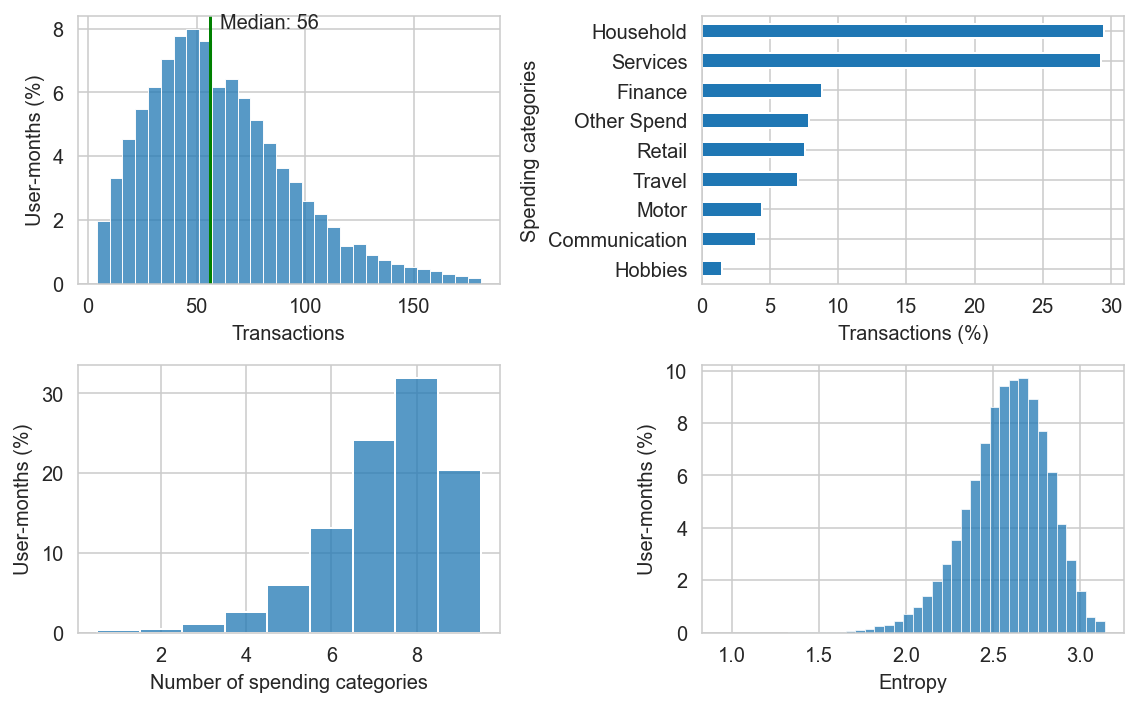

In [7]:
data = df
write = False

figs.txns_breakdowns_and_entropy(data, write=write)

## Case studies

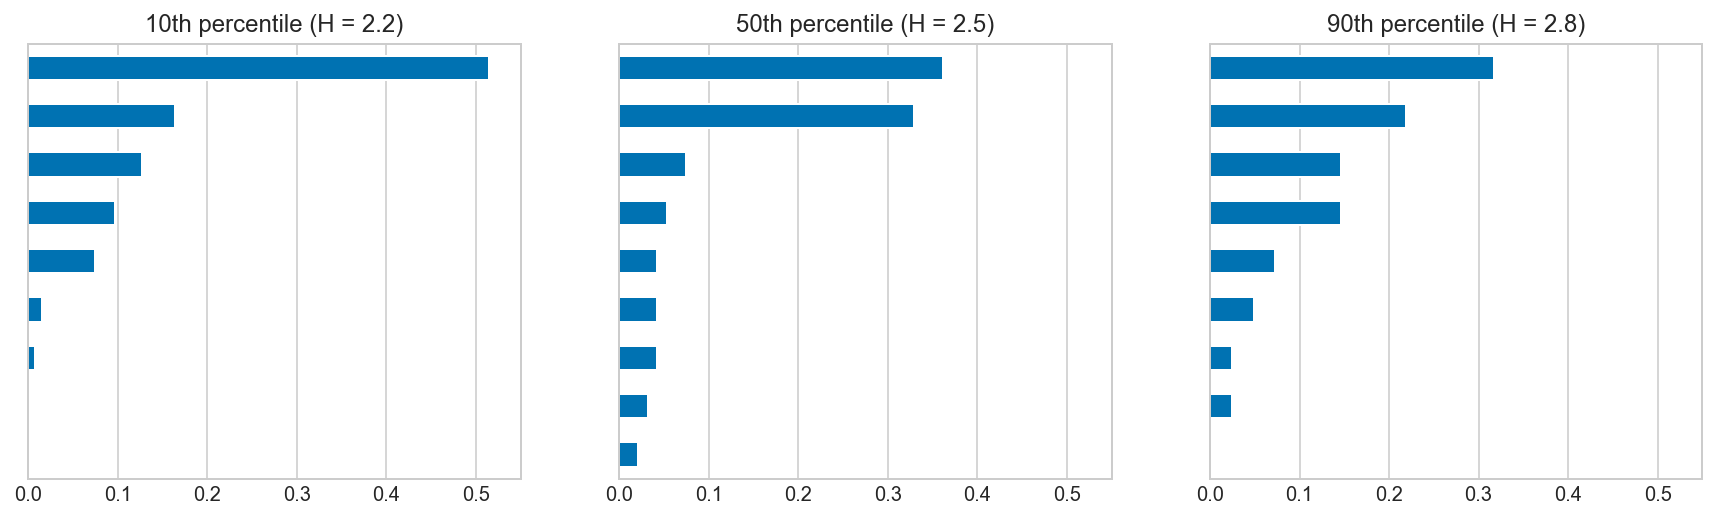

In [8]:
def make_spend_data(df):
    """Retains only spending transactions."""
    df = df[df.tag_group.eq("spend")].copy()
    df["tag"] = df.tag.cat.remove_unused_categories()
    return df


def entropy_pct_case_study(df, pct):
    """Returns first user-month with entropy score at specified percentile."""
    pct_val = np.nanpercentile(df.entropy_sptac, pct)
    pct_data = df[df.entropy_sptac.eq(pct_val)]
    pct_data = pct_data.set_index(["ym", "user_id"])
    first_user_month = pct_data.index.unique()[0]
    return pct_data.loc[first_user_month].reset_index()


def spend_breakdown(df, ax=None):
    """Plots breakdown of spending transactions across tags."""
    spend = df[df.tag_group.eq("spend")].copy()
    spend.tag.value_counts(ascending=True, normalize=True).plot(
        kind="barh", yticks=None, ax=ax
    )


def entropy_pct_case_studies(df, percentiles=None, **kwargs):
    """Shows spend txns breakdown for entropy percentiles sample users."""
    if percentiles is None:
        percentiles = [10, 50, 90]
    num_plots = len(percentiles)
    spend_data = make_spend_data(df)
    fig, ax = plt.subplots(1, num_plots, **kwargs)
    for i, pct in enumerate(percentiles):
        data = entropy_pct_case_study(spend_data, pct)
        entropy = data.entropy_sptac[0]
        title = f"{pct}th percentile (H = {entropy:.1f})"
        spend_breakdown(data, ax=ax[i])
        ax[i].set(title=title)
        ax[i].set_xlim(0, 0.55)
        ax[i].get_yaxis().set_ticks([])
    return fig, ax


entropy_pct_case_studies(df, figsize=(15, 4));

## By year

We'd expect the cross-sectional distribution for different years to look very similar. The below figure confirms this.

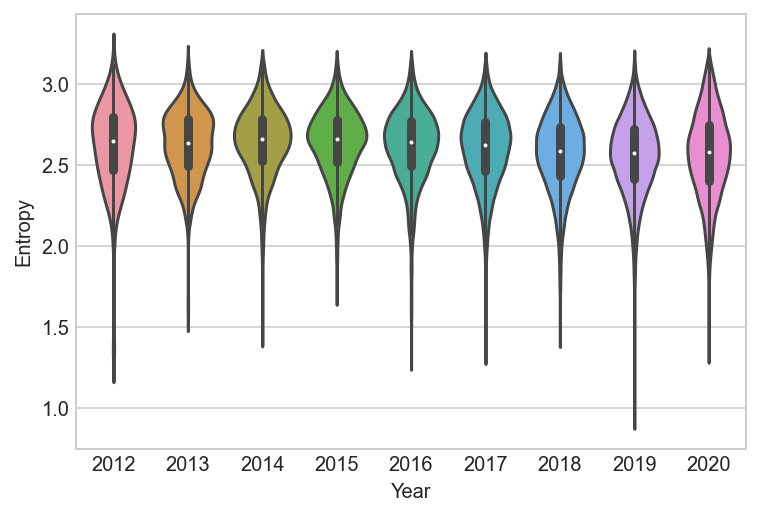

In [9]:
def make_data(df):
    return (
        df.groupby([df.date.dt.year, "user_id", "ym"]).entropy_sptac.first().reset_index()
    )


def make_figure(data):
    fig, ax = plt.subplots()
    sns.violinplot(data=data, ax=ax, x="date", y="entropy_sptac")
    ax.set(xlabel="Year", ylabel="Entropy")


data = make_data(df)
make_figure(data)

# Entropy over time

## Within user variation

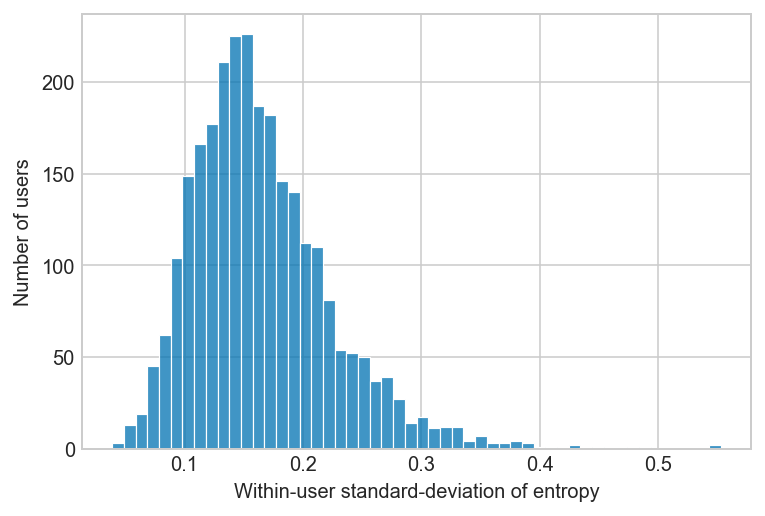

In [10]:
def make_data(df):
    return (
        df.groupby(["user_id", "ym"])
        .entropy_sptac.first()
        .groupby(["user_id"])
        .std()
        .reset_index()
    )


def make_figure(data):
    fig, ax = plt.subplots()
    sns.histplot(data=data, ax=ax, x="entropy_sptac")
    ax.set(ylabel="Number of users", xlabel="Within-user standard-deviation of entropy")


data = make_data(df)
make_figure(data)